# Chinese Calligraphy Generation

References

[1] Tero Karras, Timo Aila, Samuli Laine, and Jaakko Lehtinen. Progressive Growing of GANs for Improved Quality, Stability, and Variation. https://arxiv.org/abs/1710.10196 <br>
[2] Lars Mescheder, Andreas Geiger, and Sebastian Nowozin. Which Training Methods for GANs do actually Converge? https://arxiv.org/abs/1801.04406 <br>
[3] Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu. and Song Han. Differentiable Augmentation for Data-Efficient GAN Training. https://arxiv.org/abs/2006.10738 <br>
[4] Github repository: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/ProGAN <br>
[5] Github repository: https://github.com/GaParmar/clean-fid <br>
[6] Github repository: https://github.com/mit-han-lab/data-efficient-gans <br>
[7] Kaggle dataset: https://www.kaggle.com/datasets/yuanhaowang486/chinese-calligraphy-styles-by-calligraphers <br>
[8] Kaggle notebook: https://www.kaggle.com/code/theoviel/conditional-progan-30-public <br>

In [28]:
from math import log2
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import shutil
import pandas as pd

*   Dataset from kaggle [7]
*   Each calligrapher's writings in the dataset are separated into two folders, 'train' and 'test'
*   For training, combine images in both 'train' and 'test' into one folder, 'dataset'
*   Specific codes omitted

In [35]:
print("Number of training images: {}".format(len(os.listdir('/content/dataset'))))

Number of training images: 6763


In [12]:
DATASET                 = '/content/dataset'
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda"
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [16, 16, 16, 16, 16]
image_size              = 64
CHANNELS_IMG            = 3
Z_DIM                   = 512
IN_CHANNELS             = 512
PROGRESSIVE_GAMMAS      = [10, 10, 10, 20, 80]        # Use larger gamma for higher resolution
PROGRESSIVE_EPOCHS      = [60, 120, 120, 180, 240]

In [13]:
class CaligraphyDataset(torch.utils.data.Dataset):
    def __init__(self, transform):
        def get_images():
            images = [x for x in os.listdir('dataset') if x.lower().endswith('jpg')]
            return images

        self.images = get_images()
        self.transform = transform


    def __len__(self):
        return len(self.images)


    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join('dataset', image_name)
        image = Image.open(image_path)
        return self.transform(image)

In [15]:
# Random horizontal flip is not a valid data augmentation due to the special property of Chinese characters
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = CaligraphyDataset(transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset

Custom layers [1, 4, 8]

In [16]:
class ELConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ELConv2d, self).__init__()
        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        self.padding = padding
        self.fan_in = in_channels * kernel_size * kernel_size
        self.scale = (2 / self.fan_in) ** (0.5)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return F.conv2d(input=x,
                        weight=self.weight * self.scale,
                        bias=self.bias,
                        stride=self.stride,
                        padding=self.padding)

class ELConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=1, padding=0):
        super(ELConvTranspose2d, self).__init__()
        self.weight = nn.Parameter(torch.zeros(in_channels, out_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        self.padding = padding
        self.fan_in = in_channels
        self.scale = (2 / self.fan_in) ** (0.5)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return F.conv_transpose2d(input=x,
                                  weight=self.weight * self.scale,
                                  bias=self.bias,
                                  stride=self.stride,
                                  padding=self.padding)

class ELLinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ELLinear, self).__init__()
        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.fan_in = in_channels
        self.scale = (2 / self.fan_in) ** (0.5)

    def forward(self, x):
        return F.linear(input=x,
                        weight=self.weight * self.scale,
                        bias=self.bias)

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

class MiniBatchSTD(nn.Module):
    def __init__(self):
        super(MiniBatchSTD, self).__init__()
        self.alpha = 1e-8

    def forward(self, x):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = torch.sqrt(y.pow(2).mean(dim=0, keepdim=False) + self.alpha)
        y = y.mean()
        y = y.repeat(batch_size, 1, height, width)
        y = torch.cat([x, y], 1)
        return y

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = ELConv2d(in_channels, out_channels)
        self.conv2 = ELConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

Progressive generator [1, 4, 8]

In [17]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        self.initial_block = nn.Sequential(
            PixelNorm(),
            ELLinear(z_dim, in_channels * 4 * 4),
            nn.Unflatten(1, (in_channels, 4, 4)),
            nn.LeakyReLU(0.2),
            PixelNorm(),
            ELConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )  # 4

        self.prog_blocks = nn.ModuleList([
            ConvBlock(in_channels, in_channels),              # 8
            ConvBlock(in_channels, in_channels),              # 16
            ConvBlock(in_channels, in_channels),              # 32
            ConvBlock(in_channels, in_channels // 2),         # 64
        ])

        self.to_rgb_layers = nn.ModuleList([
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 4
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 8
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 16
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 32
            ELConv2d(in_channels // 2, img_channels, kernel_size=1, stride=1, padding=0),   # 64
        ])

    def forward(self, x, alpha, steps):
        assert alpha >= 0 and alpha <= 1, "Value of alpha out of range"

        out = self.initial_block(x)

        if steps == 0:
            return self.to_rgb_layers[0](out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        if alpha < 1:
            final_upscaled = self.to_rgb_layers[steps - 1](upscaled)
            final_out = self.to_rgb_layers[steps](out)
            return alpha * final_out + (1 - alpha) * final_upscaled
        else:
            final_out = self.to_rgb_layers[steps](out)
            return final_out

Progressive discriminator [1, 4, 8]

In [18]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.from_rgb_layers = nn.ModuleList([
            ELConv2d(img_channels, in_channels // 2, kernel_size=1, stride=1, padding=0),   # 64
            ELConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0),        # 32
            ELConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0),        # 16
            ELConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0),        # 8
            ELConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0),        # 4
        ])

        self.prog_blocks = nn.ModuleList([
            ConvBlock(in_channels // 2, in_channels, use_pixelnorm=False),  # 64
            ConvBlock(in_channels, in_channels, use_pixelnorm=False),  # 32
            ConvBlock(in_channels, in_channels, use_pixelnorm=False),  # 16
            ConvBlock(in_channels, in_channels, use_pixelnorm=False),  # 8
        ])

        self.final_block = nn.Sequential(
            ELConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            ELConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            ELLinear(in_channels, 1)  # 4
        )

        self.minibatch_std = MiniBatchSTD()
        self.leaky = nn.LeakyReLU(0.2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, alpha, steps):
        assert alpha >= 0 and alpha <= 1, "Value of alpha out of range"

        cur_step = len(self.prog_blocks) - steps
        out = self.leaky(self.from_rgb_layers[cur_step](x))

        if steps == 0:
            out = self.minibatch_std(out)
            return self.final_block(out)

        if alpha < 1:
            downscaled = self.leaky(self.from_rgb_layers[cur_step + 1](self.avg_pool(x)))
            out = self.avg_pool(self.prog_blocks[cur_step](out))
            out = alpha * out + (1 - alpha) * downscaled
        else:
            out = self.avg_pool(self.prog_blocks[cur_step](out))

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out)

Zero-centered gradient penalty only on real images [2] <br>
*   Part of the non-saturating GAN loss with R1 regularization

In [19]:
def gradient_penalty(disc, real, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    real.requires_grad_(True)

    real_scores = disc(real, alpha, train_step)

    gradient = torch.autograd.grad(
        inputs=real,
        outputs=real_scores,
        grad_outputs=torch.ones_like(real_scores),
        create_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean(gradient_norm ** 2)
    return gradient_penalty

Exponential moving average (EMA) with a ramp up. Compared with not having it, EMA is able to


*   Generate smoother images
*   Train longer and eventaully achieve better FID



In [20]:
class EMA:
    def __init__(self, decay=0.999, progressive=True):
        assert decay > 0 and decay < 1, "Value of decay out of range"
        self.decay = decay
        self.num_updates = 0 if progressive else None

    def initialize(self, model):
        model.eval()
        for p in model.parameters():
            p.requires_grad = False

    def copy(self, model_ema, model_tgt):
        ema = dict(model_ema.named_parameters())
        tgt = dict(model_tgt.named_parameters())

        with torch.no_grad():
            for p_ema, p_tgt in zip(ema.values(), tgt.values()):
                p_ema.copy_(p_tgt)

    def update(self, model_ema, model_tgt):
        decay = self.decay
        if self.num_updates is not None:
            decay = min(decay, (1 + self.num_updates) / (10 + self.num_updates))
            self.num_updates += 1

        ema = dict(model_ema.named_parameters())
        tgt = dict(model_tgt.named_parameters())

        with torch.no_grad():
            for p_ema, p_tgt in zip(ema.values(), tgt.values()):
                p_ema.mul_(decay).add_(p_tgt, alpha=1-decay)

    def reset(self, num_updates=0):
        if self.num_updates is not None:
            self.num_updates = num_updates

Differentiable augmentation [3, 6]
  
*   Important due to the lack of data coming from <br>
     1. Insufficient number of training images (only 6763 images)
     2. Limited ways for conventional data augmentation (random horizontal flip not valid)

*   Without it, the model suffers from mode collapse before even reaching 64px resolution

In [21]:
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738
# https://github.com/mit-han-lab/data-efficient-gans


def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)

    # Add indexing='ij in meshgrid to prevent getting a warning
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
        indexing = 'ij'
    )

    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)

    # Add indexing='ij in meshgrid to prevent getting a warning
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
        indexing = 'ij'
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

Training loop

In [22]:
def train_fn(
    disc,
    gen,
    loader,
    dataset,
    step,
    alpha,
    disc_opt,
    gen_opt,
    gen_ema,
    ema,
    disc_scaler,
    gen_scaler,
    policy
):
    loop = tqdm(loader, leave=True)
    for real in loop:
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            real = real.to(DEVICE)
            cur_batch_size = real.shape[0]
            noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
            fake = gen(noise, alpha, step)

            real_aug = DiffAugment(real, policy=policy)
            fake_aug = DiffAugment(fake, policy=policy)

            disc_real = disc(real_aug, alpha, step)
            disc_fake = disc(fake_aug.detach(), alpha, step)
            real_gp = gradient_penalty(disc, real_aug, alpha, step, device=DEVICE)
            r1 = PROGRESSIVE_GAMMAS[step] / 2 * real_gp
            disc_loss = r1 + torch.mean(F.softplus(-disc_real)) + torch.mean(F.softplus(disc_fake))

        disc_opt.zero_grad()
        disc_scaler.scale(disc_loss).backward()
        disc_scaler.step(disc_opt)
        disc_scaler.update()

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            gen_fake = disc(fake_aug, alpha, step)
            gen_loss = torch.mean(F.softplus(-gen_fake))

        gen_opt.zero_grad()
        gen_scaler.scale(gen_loss).backward()
        gen_scaler.step(gen_opt)
        gen_scaler.update()

        ema.update(gen_ema, gen)

        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1.0)

        loop.set_postfix(
            r1=r1.item(),
            gen_loss=gen_loss.item(),
            disc_loss=disc_loss.item(),
            alpha = alpha
        )
    return alpha, gen_loss.item(), disc_loss.item(), gen, gen_ema

In [25]:
gen = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
disc = Discriminator(IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)

gen_opt = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0, 0.99))
disc_opt = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0, 0.99))

gen_ema = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)

ema = EMA(decay=0.999, progressive=True)
ema.initialize(gen_ema)

gen_scaler = torch.cuda.amp.GradScaler()
disc_scaler = torch.cuda.amp.GradScaler()

In [26]:
policy = 'color,translation,cutout'

Training

*   Strating from 4px, resolution increases by a factor of 2 each time
*   Finish at 64px, which is the resolution of the training images

In [ ]:
step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-5
    loader, dataset = get_loader(4 * 2 ** step)
    print(f"Current image size: {4 * 2 ** step}")
    print(f"Current gamma: {PROGRESSIVE_GAMMAS[step]}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha, gen_loss, disc_loss, gen, gen_ema = train_fn(
            disc,
            gen,
            loader,
            dataset,
            step,
            alpha,
            disc_opt,
            gen_opt,
            gen_ema,
            ema,
            disc_scaler,
            gen_scaler,
            policy
        )
    print("Step {} finished".format(step))
    step += 1
    ema.reset()

*   FID scores are monitored per 5 epochs during training using clean-FID [5] with 10000 generated images
*   Weights are chosen when clean-FID monitored during training reaches minimum
*   For this model, clean-FID is often sligtly larger than the official implementation of FID to Pytorch
*   Final FID score is calculated using 50000 generated images, which is slightly smaller than using only 10000 images
*   Specific codes omitted

In [4]:
# Clean-FID scores monitored during training are saved in my personal google drive
df_lgq = pd.read_csv(os.path.join('drive', 'MyDrive', 'Caligraphy', 'FID_Liu_Gongquan_style.csv'))
df_mf = pd.read_csv(os.path.join('drive', 'MyDrive', 'Caligraphy', 'FID_Mi_Fu_style.csv'))

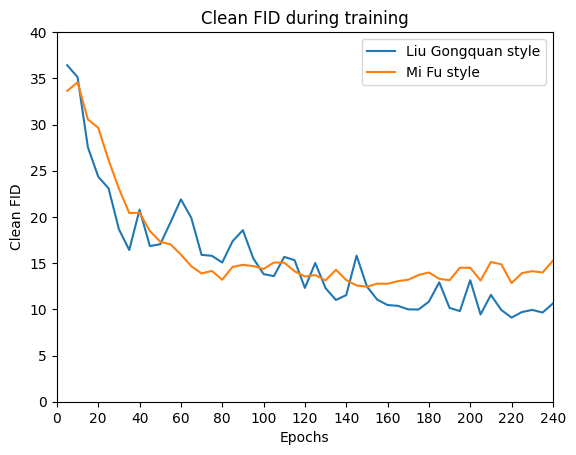

In [21]:
plt.plot([5*x for x in range(1,49)], df_lgq['FID'], label='Liu Gongquan style')
plt.plot([5*x for x in range(1,49)], df_mf['FID'], label='Mi Fu style')
plt.title('Clean FID during training')
plt.xlabel('Epochs')
plt.ylabel('Clean FID')
plt.xticks(np.arange(0, 241, 20))
plt.yticks(np.arange(0, 41, 5))
plt.xlim(0, 240)
plt.ylim(0, 40)
plt.legend()
plt.show()